In [1]:
import numpy as np
import matplotlib.pyplot as plt 

class MultiArmBandit:
    def __init__(self, k=10, epsilon=0.1):
        self.k = k
        self.reward = np.random.randn(k)
        self.Q = None
        self.N = None
        self.initQ()
        self.check_epsilon(epsilon)
        
    def initQ(self):
        self.Q = np.array([0.0]*self.k)
        self.N = [0]*self.k
        
    def check_epsilon(self, epsilon):
        if 0.0 <= epsilon <= 1.0:
            self.epsilon = epsilon
        else:
            raise ValueError("epsilon must be between 0 and 1")
               
    def epsilon_greedy(self):  
        if np.random.random_sample() < self.epsilon:
            action = np.random.choice(self.k)
        else:
            _max = self.Q.max()     
            max_list = np.where(self.Q == _max)[0]
            action = np.random.choice(max_list)
        return action
    
    def updateQ(self, action):
        self.N[action]+=1    
        reward = np.random.normal(self.reward[action] , 1, 1)       
        self.Q[action]+= (reward -self.Q[action])/self.N[action]
        return reward

    def pull_lever_once(self):        
        action = self.epsilon_greedy()
        return self.updateQ(action)
            
    def pull_lever(self,num_pull=1000):    
        for pull in range(num_pull):
            self.pull_lever_once()

In [2]:
bandit = MultiArmBandit()
bandit.pull_lever(100000)
print(f"True Rewards : \n {bandit.reward} \n")   
print(f"Q : \n {bandit.Q} \n")   
print(f"N : \n {bandit.N} \n")   

True Rewards : 
 [-0.27307545  0.44808063  0.08145812 -1.01113053 -1.34531311 -0.76083626
 -1.13408985 -1.55223791 -1.04536293  1.97323379] 

Q : 
 [-0.33429463  0.47981147  0.10559805 -1.02533783 -1.3442177  -0.79523066
 -1.11763782 -1.56738157 -0.95161963  1.96942238] 

N : 
 [973, 1050, 1038, 977, 1078, 1007, 985, 981, 982, 90929] 



In [3]:
class Simulation:
    def __init__(self, bandit = MultiArmBandit, num_sim = 2000, num_pull=1000,epsilon=0.1):
        self.bandit = bandit
        self.num_sim = num_sim
        self.num_pull = num_pull
        self.epsilon= epsilon
    
    def run(self):
        historical_average = np.zeros(self.num_pull)
        for sim in range(self.num_sim):
            bandit = self.bandit(epsilon=self.epsilon)           
            for i in range(self.num_pull):
                reward = bandit.pull_lever_once()
                historical_average[i]+=reward              
        return historical_average/self.num_sim

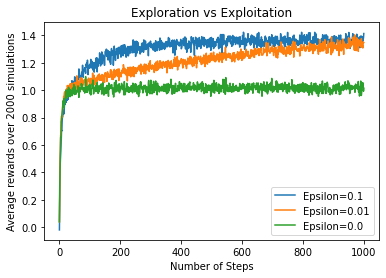

In [72]:
f, ax = plt.subplots()
epsilons = [0.1,0.01,0.0]
for eps in epsilons:
    sim = Simulation(epsilon=eps,num_sim = 2000)
    historical_average = sim.run()
    ax.plot(historical_average)
    plt.title("Exploration vs Exploitation")
    plt.xlabel("Number of Steps")
    plt.ylabel("Average rewards over 2000 simulations")
    plt.legend(("Epsilon=0.1","Epsilon=0.01","Epsilon=0.0"))

## Non Stationary Rewards

In [27]:
class NonStationaryMultiArmBandit(MultiArmBandit):
    def __init__(self, constant_alpha=True, **kwargs):
        super().__init__(**kwargs)
        self.constant_alpha = constant_alpha

    def updateQ(self, action):
        self.N[action] += 1
        reward_delta = np.random.normal(0, 0.1, self.k)
        self.reward += reward_delta
        reward = np.random.normal(self.reward[action], 1, 1)
        if self.constant_alpha:
            self.Q[action] += (reward - self.Q[action])*0.1
        else:
            self.Q[action] += (reward - self.Q[action])/self.N[action]
        return reward

In [84]:
bandit = NonStationaryMultiArmBandit()
bandit.pull_lever1(100000)
print(f"True Rewards : \n {bandit.reward} \n")   
print(f"Q : \n {bandit.Q} \n")   
print(f"N : \n {bandit.N} \n")   

True Rewards : 
 [ 18.61734253 -10.92202784   9.25248093 -15.0585759   17.86651149
 -42.40587647 -46.89786737  -8.10577937 -30.28779178 -66.88257555] 

Q : 
 [ 17.72409159  -9.7839072    7.73146582 -12.75627318  17.88415827
 -42.11937238 -44.6132347   -7.57335576 -26.3518612  -65.12319826] 

N : 
 [3025, 995, 76821, 999, 9824, 3102, 1000, 947, 2248, 1039] 



In [24]:
class NonStationarySimulation(Simulation):
    def __init__(self,
                 constant_alpha=True,
                 bandit=NonStationaryMultiArmBandit, **kwargs):
        super().__init__(**kwargs)
        self.constant_alpha = constant_alpha
        self.bandit = bandit

    def run(self):
        historical_average = np.zeros(self.num_pull)
        for sim in range(self.num_sim):
            if sim % 100 == 0:
                print(sim)
            bandit = self.bandit(epsilon=self.epsilon,
                                 constant_alpha=self.constant_alpha
                                 )
            for i in range(self.num_pull):
                reward = bandit.pull_lever_once()
                historical_average[i] += reward
        return historical_average/self.num_sim

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


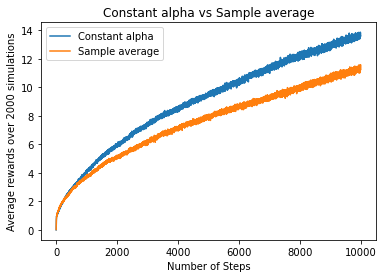

In [76]:
f, ax = plt.subplots()
eps = 0.1
constant_alphas = [True, False]
for constant_alpha in constant_alphas:
    sim = Simulation(epsilon=eps,num_sim = 2000,num_pull=10000, constant_alpha=constant_alpha)
    historical_average = sim.run()
    ax.plot(historical_average)c
    plt.title("Constant alpha vs Sample average")
    plt.xlabel("Number of Steps")
    plt.ylabel("Average rewards over 2000 simulations")
    plt.legend(("Constant alpha","Sample average"))

## Optimistic Initial Value

In [86]:
class OptimisticInitialValueBandit(MultiArmBandit):
    def __init__(self, optimistic=True, **kwargs):
        self.optimistic = optimistic
        super().__init__(**kwargs)        

    def initQ(self):
        initial_value = 10.0 if self.optimistic else 0.0
        self.Q = np.array([initial_value]*self.k)
        self.N = [0]*self.k   

    def updateQ(self, action):
        self.N[action]+=1    
        reward = np.random.normal(self.reward[action] , 1, 1)       
        self.Q[action]+= (reward -self.Q[action])*0.1
        return reward

In [88]:
class OptimisticInitialValueSimulation(Simulation):
    def __init__(self, bandit=OptimisticInitialValueBandit,
                 optimistic=True, **kwargs):
        super().__init__(**kwargs)
        self.bandit = bandit
        self.optimistic = optimistic
        
    def run(self):
        historical_average = np.zeros(self.num_pull)
        for sim in range(self.num_sim):
            if sim % 500 == 0:
                print(sim)
            bandit = self.bandit(optimistic=self.optimistic)
            for i in range(self.num_pull):
                reward = bandit.pull_lever_once()
                historical_average[i] += reward
        return historical_average/self.num_sim  

0
500
1000
1500
0
500
1000
1500


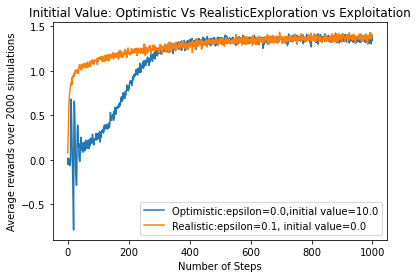

In [89]:
f, ax = plt.subplots()
epsilons = [0.0, 0.10]
optimistic = [True, False]
for i in range(2):
    sim = OptimisticInitialValueSimulation(bandit=OptimisticInitialValueBandit, 
                     epsilon=epsilons[i],
                     optimistic=optimistic[i],                     
                     num_sim=2000)
    historical_average = sim.run()
    ax.plot(historical_average)
    plt.title("Inititial Value: Optimistic Vs RealisticExploration vs Exploitation")
    plt.xlabel("Number of Steps")
    plt.ylabel("Average rewards over 2000 simulations")
    plt.legend(("Optimistic:epsilon=0.0,initial value=10.0", 
                "Realistic:epsilon=0.1, initial value=0.0"))

## Upper Confidence Bound 

In [43]:
class UCB_MultiArmBandit(MultiArmBandit):
    def __init__(self, ucb=True, c=2, **kwargs):
        super().__init__(**kwargs)        
        self.total_step = 0
        self.ucb = ucb
        self.c = 2
           
    def ucb_formula(self,action):
        """upper confidence bound with smoothing"""
        upper_bound = self.Q[action] + self.c*np.sqrt(np.log(self.total_step+1)/(self.N[action]+1))        
        return upper_bound

    def ucb_argmax(self):  
        upper_bounds = [self.ucb_formula(action)for action in range(self.k)]
        _max = np.array(upper_bounds).max()  
        max_list = np.where(upper_bounds == _max)[0]
        action = np.random.choice(max_list)
        return action

    def updateQ(self, action):
        self.N[action]+=1 
        self.total_step += 1
        reward = np.random.normal(self.reward[action] , 1, 1)       
        self.Q[action]+= (reward -self.Q[action])/self.N[action]
        return reward
    
    def pull_lever_once(self): 
        if self.ucb:
            action = self.ucb_argmax()
        else:
            action = self.epsilon_greedy()
        return self.updateQ(action)

In [47]:
class UCB_Simulation(Simulation):
    def __init__(self, bandit=UCB_MultiArmBandit,ucb=True, **kwargs):
        super().__init__(**kwargs)
        self.bandit = bandit
        self.ucb=ucb
    
    def run(self):
        historical_average = np.zeros(self.num_pull)
        for sim in range(self.num_sim):
            bandit = self.bandit(epsilon=self.epsilon,ucb=self.ucb)           
            for i in range(self.num_pull):
                reward = bandit.pull_lever_once()
                historical_average[i]+=reward              
        return historical_average/self.num_sim

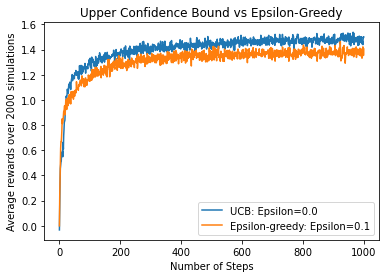

In [46]:
f, ax = plt.subplots()
eps = [0.0, 0.1]
ucb = [True, False]
for i in range(2):
    sim = UCB_Simulation(epsilon=eps[i],num_sim = 2000,ucb=ucb[i])
    historical_average = sim.run()
    ax.plot(historical_average)
    plt.title("Upper Confidence Bound vs Epsilon-Greedy")
    plt.xlabel("Number of Steps")
    plt.ylabel("Average rewards over 2000 simulations")
    plt.legend(("UCB: Epsilon=0.0","Epsilon-greedy: Epsilon=0.1"))